# Introduction
This notebook shows how to use the [Microsoft Graph Security API](https://aka.ms/graphsecuritydocs). It defines a Python wrapper for calling the API 
and several Jupyter magics to make it easy to access [Microsoft Graph Security alerts](https://aka.ms/graphsecurityalerts). While the APIs are documented and supported,
the wrapper in this notebook is a sample and is not an official programming interface.

Author: [Microsoft Graph Security Team](graphsecfeedback@microsoft.com) (Inspired by [@JohnLaTwC](https://twitter.com/JohnLaTwC))

## Links to Microsoft Graph Security API documentation and other samples

[Overview of Microsoft Graph Security](https://aka.ms/graphsecuritydocs)

[What are alerts?](https://aka.ms/graphsecurityalerts)

[Alert Schema - list of properties and descriptions](https://docs.microsoft.com/en-us/graph/api/resources/alert?view=graph-rest-1.0) 

[Authorization - Application-only and User-Delegated](https://docs.microsoft.com/graph/security-authorization?view=graph-rest-1.0)

[More Samples](https://aka.ms/graphsecurityapicode)

[OData query examples](https://docs.microsoft.com/graph/query-parameters)

# Authentication - Initialize secrets

Download this notebook and follow the steps below to get the application ID and secret that you can use to authenticate and get data from your Azure Active Directory (Azure AD) tenant using this notebook. 
1.	[Register your application](https://docs.microsoft.com/en-us/graph/auth-v2-service#1-register-your-app) for this notebook in Azure AD in application only mode. 
2.	[Configure permissions](https://docs.microsoft.com/en-us/graph/auth-v2-service#2-configure-permissions-for-microsoft-graph) and be sure to add the `SecurityEvents.ReadWrite.All` permission to your application.
3. Get your Azure AD tenant administrator to [grant tenant administration consent](https://docs.microsoft.com/en-us/graph/auth-v2-service#3-get-administrator-consent) to your application. This is a one-time activity unless permissions change for the application. 

When your app is registered to call the Microsoft Graph Security API you need to pass the application ID and application secret from the above mentioned steps in to this sample. 

Use either plain text input to enter your secret in the `get_secret` function or get it from your envionment variable in the `get_secret` function below the first one. Use only one of these functions to get secret. 

In [13]:
def get_secret(secret_name):
    return {'GRAPHSEC_DEMO_appId':'<<Enter your registered application ID>>',
            'GRAPHSEC_DEMO_appSecret':'<<Enter you application secret>>',
            'GRAPHSEC_DEMO_tenantId':'<<Enter your tenant ID>>',
            'VT_API_KEY':'<<Enter optional VirusTotal API Key>>'}[secret_name]

In [ ]:
## e.g. custom way to access secrets
def get_secret(secret_name):
    import os
    return os.environ.get(secret_name)

In [14]:
appId = get_secret('GRAPHSEC_DEMO_appId')
appSecret = get_secret('GRAPHSEC_DEMO_appSecret') 
tenantId = get_secret('GRAPHSEC_DEMO_tenantId')
vt_api_key = get_secret('VT_API_KEY')
print("If your secrets were initialized properly you should see your tenant id.\nTenant Id: %s " % tenantId)

If your secrets were initialized properly you should see your tenant id.
Tenant Id: <<Enter your tenant ID>> 


# Getting Started
All the API Wrapper code is below. Activate it by clicking in the cell and hitting Shift+Enter

In [3]:
# -------------------------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License. 
# --------------------------------------------------------------------------

## https://aka.ms/graphsecuritydocs

import json
import urllib.request
import urllib.parse
import pandas as pd
import re
from IPython.core.magic import (register_line_magic, register_cell_magic,
                                register_line_cell_magic)

SPLIT_DELIMS = '[\[\] ;\n\t|,xX"\']'
@register_line_cell_magic
def hash(line, cell=None):
    if cell is None:
        return line
    else:    
        results = []
        for f in re.split(SPLIT_DELIMS,cell):
            p = re.compile('^[a-f0-9]{32}$'
                           '|^[a-f0-9]{40}$'
                           '|^[a-f0-9]{64}$'
                           ,re.IGNORECASE)
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        
        return results           

# We delete these to avoid name conflicts for automagic to work
del hash 

@register_line_cell_magic
def vthash(line, cell=None):
    if cell is None:
        return MsftGraphSec_api.vtresults([line])
    else:    
        results = []
        for f in re.split(SPLIT_DELIMS,cell):
            p = re.compile('^[a-f0-9]{32}$'
                           '|^[a-f0-9]{40}$'
                           '|^[a-f0-9]{64}$'
                           ,re.IGNORECASE)
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        
        if len(results) == 0:
            return
        return MsftGraphSec_api.vtresults(results)
           

# We delete these to avoid name conflicts for automagic to work
del vthash 

@register_line_cell_magic
def graph_sec_file(line, cell=None):
    if cell is None:
        return MsftGraphSec_api.alerts(filehash=line)
    else:    
        results = []
        for f in re.split(SPLIT_DELIMS,cell):
            p = re.compile('^[a-f0-9]{32}$'
                           '|^[a-f0-9]{40}$'
                           '|^[a-f0-9]{64}$'
                           ,re.IGNORECASE)
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        
        if len(results) == 0:
            return
        dfs = []
        for filehash in results:
            dfs.append(MsftGraphSec_api.alerts(filehash=filehash))
        import pandas as pd
        return pd.concat(dfs)
            
# Delete these to avoid name conflicts for automagic to work
del graph_sec_file

@register_line_cell_magic
def graph_sec_machine(line, cell=None):
    if cell is None:
        if re.match('^[a-f0-9]{40}$', line):
            return MsftGraphSec_api.machines(machineid=line)
        else:
            return MsftGraphSec_api.machines(filterstr="$filter=ComputerDnsName eq '%s'" % line)
    else:    
        results = []
        for f in re.split(SPLIT_DELIMS,cell):
            p = re.compile('^[a-f0-9]{40}$',re.IGNORECASE)
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        
        dfs = []

        # if we did not get any machine Ids, treat them as ComputerDnsNames
        if len(results) == 0:
            results = cell.split('\n')
            for hostname in results:
                dfs.append(MsftGraphSec_api.machines(filterstr="$filter=ComputerDnsName eq '%s'" % hostname))
        else:
            for machine_id in results:
                dfs.append(MsftGraphSec_api.machines(machineid=machine_id))
        import pandas as pd
        return pd.concat(dfs)
            
# Delete these to avoid name conflicts for automagic to work
del graph_sec_machine 

@register_line_cell_magic
def graph_sec_alert(line, cell=None):
    if cell is None:
        return MsftGraphSec_api.alerts(alertid=line)
    else:    
        results = []
        for f in re.split(SPLIT_DELIMS,cell):
            p = re.compile('^[{(]?[0-9A-F]{8}[-]?(?:[0-9A-F]{4}[-]?){3}[0-9A-F]{12}[)}]?$',re.IGNORECASE)
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        if len(results) == 0:
            return
        dfs = []
        for alert_id in results:
            dfs.append(MsftGraphSec_api.alerts(alertid=alert_id))
        import pandas as pd
        return pd.concat(dfs)

# Delete these to avoid name conflicts for automagic to work
del graph_sec_alert 

@register_line_cell_magic
def graph_sec_ip(line, cell=None):
    if cell is None:
        return MsftGraphSec_api.ips(ip=line)
    else:    
        results = []
        for f in re.split(SPLIT_DELIMS,cell):
            p = re.compile('^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$')
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        if len(results) == 0:
            return
        dfs = []
        for ip in results:
            dfs.append(MsftGraphSec_api.ips(ip=ip))
        import pandas as pd
        return pd.concat(dfs)
            
# Delete these to avoid name conflicts for automagic to work
del graph_sec_ip 
        
@register_line_cell_magic
def graph_sec_action(line, cell=None):
    if cell is None:
        return MsftGraphSec_api.ips(ip=line)
    else:    
        results = []
        for f in re.split(SPLIT_DELIMS,cell):
            p = re.compile('^[a-f0-9]{8}'
                       '-[a-f0-9]{4}'
                       '-[a-f0-9]{4}'
                       '-[a-f0-9]{4}'
                       '-[a-f0-9]{12}$'
                       ,re.IGNORECASE)
            if p.search(f) is not None:
                if not f in results:
                    results.append(f)
        if len(results) == 0:
            return
        dfs = []
        for action in results:
            dfs.append(MsftGraphSec_api.machine_actions(actionid = action))
        import pandas as pd
        return pd.concat(dfs)
            
# Delete these to avoid name conflicts for automagic to work
del graph_sec_action

    
class MicrosoftGraphSecurityAPI:
    def __init__(self, tenantId, appId, appSecret, vt_api_key=None, fUsePandas=True, 
                 api_root="https://graph.microsoft.com/", api_version="v1.0"):
        url = "https://login.microsoftonline.com/%s/oauth2/v2.0/token" % (tenantId)

        self.fDebug = False

        body = {
            'client_id' : appId,
            'client_secret' : appSecret,
            'grant_type' : 'client_credentials',
            'scope': 'https://graph.microsoft.com/.default'
        }

        ## authenticate and obtain AAD Token for future calls
        data = urllib.parse.urlencode(body).encode("utf-8")
        req = urllib.request.Request(url, data)
        response = urllib.request.urlopen(req)
        jsonResponse = json.loads(response.read().decode())
        self.aadToken = jsonResponse["access_token"]
        self.headers = { 
            'Content-Type' : 'application/json',
            'Accept' : 'application/json',
            'Authorization' : "Bearer " + self.aadToken
        }
        self.fUsePandas = fUsePandas # use pandas DataFrame for collections of objects, else return a list
        self.api_root = api_root + api_version 
        self.vt_api_key = vt_api_key
        if len(self.aadToken) > 0:
            print("Connected.")
    
    def set_output_type(self, fUsePandas=True):
        self.fUsePandas = fUsePandas    

    def set_debug_output(self, fDebug=True):
        self.fDebug = fDebug    
        
    def __validate_arguments(self,args, valid_params):
        if len(args) == 0:
            raise ValueError ('argument must be one of %s' % str(list(valid_params.keys())))
        elif len(args) > 1:
            raise ValueError ('only one id can be used at a time')
        else:
            selector = next(iter(args))
            selector_value= next(iter(args.values()))
            if selector not in list(valid_params.keys()):
                raise ValueError ('argument must be one of %s' % str(list(valid_params.keys())))
        return (selector, selector_value)

    def __make_request(self,url, params=None):
 
        if self.fDebug:
            print(url)
        req = urllib.request.Request(url, headers=self.headers)
        try:
            response = urllib.request.urlopen(req)
        except urllib.error.HTTPError as e:
            print(e.code)
            if e.code == 404:
                response = e
            else:
                raise e
                
        jsonResponse = json.loads(response.read().decode())
        if type(jsonResponse) == int:
            if self.fUsePandas:
                return pd.DataFrame([jsonResponse])
            else:
                return jsonResponse
        if 'value' in jsonResponse:
            res = jsonResponse["value"]
            if len(res) == 0:
                res = {}
        else:
            res = jsonResponse     
        if self.fUsePandas:
            return pd.io.json.json_normalize(res)
        return res

    def __prepare_param_dict_from_filter_str(self, filterstr):
        get_params = {}
        for filter_param in re.split("[\?\&]+", filterstr):
            if len(filter_param)> 0:
                attr = filter_param.split('=')[0]
                val  = filter_param.split('=')[1]
                get_params[attr]= val
        return get_params
    
    def __get_json_alert(self, alertid=None):
        _pandas = self.fUsePandas
        self.fUsePandas = False
        alert_as_json = self.alerts(alertid=alertid)
        self.fUsePandas = _pandas
        return alert_as_json
    
    def alerts(self, **kwargs):
        alert_url = self.api_root + "/security/alerts"
        get_params = None
        
        valid_params = {
            'filterstr' : alert_url + '?%s',
            'alertid'   : alert_url + '/%s',
            'userid'    : alert_url + "?$filter=userStates/any(d:d/userPrincipalName eq '%s')",
            'ip'        : alert_url + "?$filter=hostStates/any(d:d/privateIpAddress eq '%s')",
            'hostfqdn'  : alert_url + "?$filter=hostStates/any(d:d/fqdn eq '%s')", 
            'filehash'  : alert_url + "?$filter=fileStates/any(d:d/fileHash/hashValue eq '%s')",
            'filename'  : alert_url + "?$filter=fileStates/any(d:d/name eq '%s')", 
            'domain'    : alert_url + "?$filter=networkConnections/any(d:d/destinationDomain eq '%s')" 
        }
        (selector, selector_value) = self.__validate_arguments(kwargs, valid_params)
        
        if selector == 'filterstr':
            get_params = self.__prepare_param_dict_from_filter_str(selector_value)
            if get_params is not None:
                url = valid_params[selector] % urllib.parse.urlencode(get_params)
        else:
            url = valid_params[selector] % selector_value
            url = urllib.parse.quote( url , safe="%/:=&?~#+!$,;'@()*[]") # Url encode spaces 

        return self.__make_request(url)
    
    def update_alert(self, alertid=None, alertbody=None):
        import requests 

        alert_url = self.api_root + "/security/alerts"
        
        valid_params = {
            'alertid'   : alert_url + '/%s'
        }
        (selector, selector_value) = self.__validate_arguments({"alertid": alertid}, valid_params)
        
        if alertbody == None:
            raise ValueError ('Request body cannot be empty')
            
        headers = self.headers
        headers['Prefer'] = "return=representation"
        
        _old_alert = self.__get_json_alert(alertid=alertid) 
        
        alertbody["vendorInformation"] = _old_alert["vendorInformation"] # vendorInformation is required to PATCH an alert
        
        url = valid_params[selector] % selector_value
        json_body = json.dumps(alertbody)
        response = requests.patch(url, json_body, headers=headers)

        jsonResponse = response.json()

        if self.fUsePandas:
            return pd.io.json.json_normalize(jsonResponse)
        return jsonResponse


       
    def users(self, **kwargs):
        user_url = self.api_root + "/users"
        
        valid_params = {
            'userid'    : user_url + '/%s'
        }
        
        (selector, selector_value) = self.__validate_arguments(kwargs, valid_params)
        
        url = valid_params[selector] % selector_value

        return self.__make_request(url)
     
   
    def vtresults(self, hashlist):
        import requests 

        url = "https://www.virustotal.com/vtapi/v2/file/report"

        headers = {'User-Agent':'VirusTotal',
                    'Content-Type':'application/json'}
        if type(hashlist) == str:
            hashlist = [hashlist]
        
        data = {"resource": ','.join(hashlist),
                "apikey": self.vt_api_key}

        response = requests.get(url, data, headers=headers)

        jsonResponse = response.json()

        if self.fUsePandas:
            return pd.io.json.json_normalize(jsonResponse)
        return r.json()
    
print("Sample Microsoft Graph Security API code loaded")

Sample Microsoft Graph Security API code loaded


In [4]:
# hit Shift-Enter in this cell

# NOTE: endpoint authorization will periodically time out and you will need to re-run this command to re-authenticate
# if you're able to call the API (client app registered properly), and you get an exception 
# with a HTTP error 401 Unauthorized, re-run this command to re-initiate the endpoint

MsftGraphSec_api = MicrosoftGraphSecurityAPI(tenantId, appId, appSecret, vt_api_key)
MsftGraphSec_api.set_debug_output()

Connected.


# Get Alerts

Let's query the most recent 5 alerts using the OData TOP keyword. The `$top=5` query will return 5 of the most recent alerts from *each* [Microsoft Graph Security alert provider](https://aka.ms/graphsecurityalerts). 

In [5]:
MsftGraphSec_api.alerts(filterstr = "$top=5")

https://graph.microsoft.com/v1.0/security/alerts?%24top=5


,activityGroupName,assignedTo,azureSubscriptionId,azureTenantId,category,closedDateTime,cloudAppStates,comments,confidence,createdDateTime,...,status,tags,title,triggers,userStates,vendorInformation.provider,vendorInformation.providerVersion,vendorInformation.subProvider,vendorInformation.vendor,vulnerabilityStates
0,None,,,63d0b44f-8610-4dd2-91fd-541ffc973399,threat,None,[],[],NaN,2019-04-20T15:11:31Z,...,newAlert,[],Traps: Malware Blocked,[],"[{'aadUserId': None, 'accountName': 'adamw', '...",Palo Alto Networks,5.0,Traps,Palo Alto Networks,[]
1,None,,,63d0b44f-8610-4dd2-91fd-541ffc973399,vulnerability,None,"[{'destinationServiceIp': None, 'destinationSe...",[],NaN,2019-04-20T15:58:31Z,...,newAlert,[endpoint],threat: vulnerability 35993,"[{'name': 'networkConnection.sourceAddresss', ...","[{'aadUserId': None, 'accountName': 'christiec...",Palo Alto Networks,8.1,NGFW,Palo Alto Networks,[]
2,None,,,63d0b44f-8610-4dd2-91fd-541ffc973399,threat,None,[],[],NaN,2019-04-20T15:33:15Z,...,newAlert,[],Traps: Malware Blocked,[],"[{'aadUserId': None, 'accountName': 'aldom', '...",Palo Alto Networks,5.0,Traps,Palo Alto Networks,[]
3,None,,,63d0b44f-8610-4dd2-91fd-541ffc973399,data,None,"[{'destinationServiceIp': None, 'destinationSe...",[],NaN,2019-04-17T10:16:36Z,...,newAlert,[],Data Filtering Alert,[],"[{'aadUserId': None, 'accountName': None, 'dom...",Palo Alto Networks,None,NG Firewall,Palo Alto Networks,[]
4,None,None,,63d0b44f-8610-4dd2-91fd-541ffc973399,data,None,"[{'destinationServiceIp': None, 'destinationSe...",[],NaN,2019-04-16T10:16:31Z,...,newAlert,[],Data Filtering Alert,[],"[{'aadUserId': None, 'accountName': 'douglasf'...",Palo Alto Networks,8.1,NGFW,Palo Alto Networks,[]
5,None,None,None,63d0b44f-8610-4dd2-91fd-541ffc973399,impossibleLoginVelocity,None,[],[],0.0,2019-04-17T18:30:45Z,...,newAlert,[],Impossible travel activity,[],"[{'aadUserId': None, 'accountName': 'douglasf'...",Cloud Application Security,3.0,,Microsoft,[]
6,,,None,63d0b44f-8610-4dd2-91fd-541ffc973399,repeatedShareActivity,None,[],[],0.0,2019-04-17T14:33:00Z,...,newAlert,[],Mass share,[],"[{'aadUserId': None, 'accountName': 'douglasf'...",Cloud Application Security,3.0,,Microsoft,[]
7,None,None,None,63d0b44f-8610-4dd2-91fd-541ffc973399,repeatedActivityShare,None,[],[],0.0,2019-04-16T16:55:36Z,...,newAlert,[],Mass share,[],"[{'aadUserId': None, 'accountName': 'douglasf'...",Cloud Application Security,3.0,,Microsoft,[]
8,None,None,None,63d0b44f-8610-4dd2-91fd-541ffc973399,repeatedShareActivity,None,[],[],0.0,2019-04-15T21:22:00Z,...,newAlert,[],Mass share,[],"[{'aadUserId': None, 'accountName': 'aldom', '...",Cloud Application Security,3.0,,Microsoft,[]
9,None,None,None,63d0b44f-8610-4dd2-91fd-541ffc973399,repeatedActivityShare,None,[],[],0.0,2019-04-15T17:10:00Z,...,newAlert,[],Mass share,[],"[{'aadUserId': None, 'accountName': 'pattif', ...",Cloud Application Security,3.0,,Microsoft,[]


# Security Management and Monitoring Scenarios
## List high severity alerts 
You can [query alerts](https://docs.microsoft.com/en-us/graph/api/alert-list?view=graph-rest-1.0) with OData queries. OData provides a simple standardized syntax for selecting properties and filtering data

A summary of the OData filters can be found [here](https://docs.microsoft.com/graph/query-parameters) <https://docs.microsoft.com/graph/query-parameters>

In [6]:
# get the top high-sev 5 alerts and select a few columns 
MsftGraphSec_api.alerts(filterstr = "$select=createdDateTime,category,title,description,id,severity,assignedTo&$filter=Severity eq 'High'&$top=5")

https://graph.microsoft.com/v1.0/security/alerts?%24select=createdDateTime%2Ccategory%2Ctitle%2Cdescription%2Cid%2Cseverity%2CassignedTo&%24filter=Severity+eq+%27High%27&%24top=5


,assignedTo,category,createdDateTime,description,id,severity,title
0,,threat,2019-04-20T15:11:31Z,Traps: Malware Blocked,5AE9CC76-B587-4401-95C7-A8C878B7FFA5,high,Traps: Malware Blocked
1,,vulnerability,2019-04-20T15:58:31Z,Vulnerability detected: Microsoft Windows Shel...,8B9A013D-4079-4B20-9014-0B9DCB558455,high,threat: vulnerability 35993
2,,threat,2019-04-20T15:33:15Z,Traps: Malware Blocked,BC9DBC0C-A72E-4F65-A197-A333318CA14E,high,Traps: Malware Blocked
3,,data,2019-04-17T10:16:36Z,Data Filtering Alert: Document labelled Confid...,53C7E3B0-8470-424C-BD40-2C9C3F9EFB81,high,Data Filtering Alert
4,,wildfire,2019-04-15T19:26:59Z,Wildfire prevention event block,399796F2-9395-49B2-A6AB-9E02162313D8,high,Wildfire prevention threat
5,None,exploit,2019-04-18T15:37:00Z,A process suspiciously tried to access the exp...,0F72C58F-1D01-4284-BB32-C53DD45B5C01,high,Exploit Guard blocked dynamic code execution
6,None,MANUAL,2019-04-16T08:13:00Z,"SQL Injection, Cross-Site Scripting. We observ...",257F2933-A145-4061-9464-2D964A91EB91,high,Active attack EXPLOITED in QA
7,,Malicious_IP,2019-04-20T14:36:57.2738949Z,Network traffic analysis indicates that your d...,0F73E38F-BA78-49F7-A71C-0A37D329E808,high,Network communication with a malicious IP
8,,DoubleExtension,2019-04-15T22:05:56.582321Z,Analysis of host data indicates an execution o...,4F12F545-97B2-420E-8FA9-2EB8FD2D6214,high,Suspicious double extension file executed
9,,ShadowCopyDelete,2019-04-15T20:11:10.6052419Z,Analysis of host data has detected a shadow co...,BA1AFA7C-206D-4450-988E-D2795D5259F5,high,Suspicious Volume Shadow Copy Activity


## Analyzing Security Data   

The results are returned as a Pandas DataFrame--a handy data structure for processing rowset oriented results. If you don't want the results in a DataFrame and instead just in a list, you can set `fUsePandas=False` when you create the MicrosoftGraphSecurityAPI class.

See the [Pandas project page](https://pandas.pydata.org/pandas-docs/stable/index.html) for more information on DataFrames.

In [7]:
# let's assign the API results to a variable so we can process them without making an API call each time
df = MsftGraphSec_api.alerts(filterstr = "$top=25&$filter=Severity eq 'High'")
print("number of rows returned = %d" % len(df))

https://graph.microsoft.com/v1.0/security/alerts?%24top=25&%24filter=Severity+eq+%27High%27
number of rows returned = 12


In [8]:
# show all the columns in the alert entity
df.columns

Index(['activityGroupName', 'assignedTo', 'azureSubscriptionId',
       'azureTenantId', 'category', 'closedDateTime', 'cloudAppStates',
       'comments', 'confidence', 'createdDateTime', 'description',
       'detectionIds', 'eventDateTime', 'feedback', 'fileStates',
       'historyStates', 'hostStates', 'id', 'lastModifiedDateTime',
       'malwareStates', 'networkConnections', 'processes',
       'recommendedActions', 'registryKeyStates', 'riskScore', 'severity',
       'sourceMaterials', 'status', 'tags', 'title', 'triggers', 'userStates',
       'vendorInformation.provider', 'vendorInformation.providerVersion',
       'vendorInformation.subProvider', 'vendorInformation.vendor',
       'vulnerabilityStates'],
      dtype='object')

In [9]:
# Let's select just the columns we want to view. This uses the Pandas syntax for selecting columns

df[['createdDateTime','category','description','id','severity']].head(5)

,createdDateTime,category,description,id,severity
0,2019-04-20T15:11:31Z,threat,Traps: Malware Blocked,5AE9CC76-B587-4401-95C7-A8C878B7FFA5,high
1,2019-04-20T15:58:31Z,vulnerability,Vulnerability detected: Microsoft Windows Shel...,8B9A013D-4079-4B20-9014-0B9DCB558455,high
2,2019-04-20T15:33:15Z,threat,Traps: Malware Blocked,BC9DBC0C-A72E-4F65-A197-A333318CA14E,high
3,2019-04-17T10:16:36Z,data,Data Filtering Alert: Document labelled Confid...,53C7E3B0-8470-424C-BD40-2C9C3F9EFB81,high
4,2019-04-15T19:26:59Z,wildfire,Wildfire prevention event block,399796F2-9395-49B2-A6AB-9E02162313D8,high


In [10]:
# let's group them by title and count their frequency
df1 = df[['id','title']].groupby('title').count().rename(index=str, columns={"id":"Alert Count"})
df1 = df1.sort_values(['Alert Count'], ascending=False)
df1

,Alert Count
title,
Traps: Malware Blocked,2
Active attack EXPLOITED in QA,1
Data Filtering Alert,1
Detected Petya ransomware indicators,1
Exploit Guard blocked dynamic code execution,1
Network communication with a malicious IP,1
Suspicious Volume Shadow Copy Activity,1
Suspicious double extension file executed,1
Suspicious process executed,1


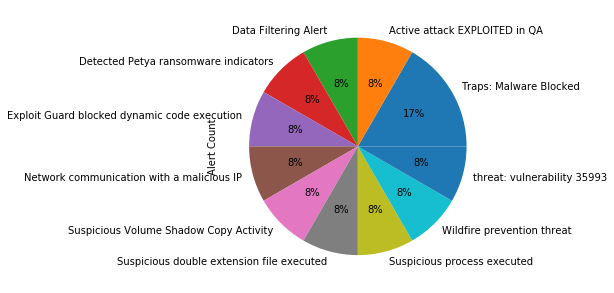

In [11]:
# show a quick pie chart using matplotlib
%matplotlib inline
plt = df1.plot.pie(y=0, figsize=(5, 5), legend=False, autopct='%1.0f%%')

# Security Investigation Scenarios
## Querying alerts by UPN (User Principal Name)

In [ ]:
MsftGraphSec_api.alerts( userid = '<<Enter user principal name>>')

## Querying alerts by machine FQDNs (Fully Qualified Domain Name)
You can query alerts by machine fqdn, user id, ip, alert id, file sha1, domain, OData query, and more

In [ ]:
MsftGraphSec_api.alerts( hostfqdn = '<<Enter host fqdn>>')

In [ ]:
# query machines associated with an alert
MsftGraphSec_api.alerts( alertid = '<<Enter alert ID>>')[['id', 'hostStates']]    #[['id', 'osBuild','osPlatform']]

In [ ]:
# query alerts by machine name
MsftGraphSec_api.alerts( filterstr = "$filter=hostStates/any(d:d/netBiosName eq '<<Enter host name>>')")

# Using different Data accesses

## Data access using Jupyter Magics

Lines starting with % signify a Jupyter magic. A "line magic" take the text after the command and does something with it. This notebook defines several magics to make it easier to access the data you need.

### Use magic on alert (entity)

`%graph_sec_alert` takes an alert id and calls the API to get details about it

In [ ]:
%graph_sec_alert <<Enter alert ID>>

#### Querying multiple alerts and regex
You can also provide a list of alert ids and invoke the cell magic with `%%graph_sec_alert`

Because alert ids have a standard syntax, the alert magic also can take arbitrary text and it will extract alert ids
by using a regex.  This is handy if you want to quickly copy-paste some text from an email or chat window that has
alert ids intermixed with conversation.

In [12]:
%%graph_sec_alert
Hi, be sure to investigate these 3 alerts and verify your results.
D3EC9E2C-29A2-4DD3-9E1E-068C9B022938
41CB1B5D-F295-40B3-8B18-DFC4AA85531E
AD5D3084-CB9A-45D5-9AA0-81EF680C20D4
Please update the ticket when completed,
Thanks! 

https://graph.microsoft.com/v1.0/security/alerts/D3EC9E2C-29A2-4DD3-9E1E-068C9B022938
https://graph.microsoft.com/v1.0/security/alerts/41CB1B5D-F295-40B3-8B18-DFC4AA85531E
https://graph.microsoft.com/v1.0/security/alerts/AD5D3084-CB9A-45D5-9AA0-81EF680C20D4


,@odata.context,activityGroupName,assignedTo,azureSubscriptionId,azureTenantId,category,closedDateTime,cloudAppStates,comments,confidence,...,status,tags,title,triggers,userStates,vendorInformation.provider,vendorInformation.providerVersion,vendorInformation.subProvider,vendorInformation.vendor,vulnerabilityStates
0,https://graph.microsoft.com/v1.0/$metadata#Sec...,None,None,,63d0b44f-8610-4dd2-91fd-541ffc973399,data,None,"[{'destinationServiceIp': None, 'destinationSe...",[],None,...,newAlert,[],Data Filtering Alert,[],"[{'aadUserId': None, 'accountName': 'douglasf'...",Palo Alto Networks,8.1,NGFW,Palo Alto Networks,[]
0,https://graph.microsoft.com/v1.0/$metadata#Sec...,None,None,1f0863f4-6125-4596-8231-55ca31b4e6a2,63d0b44f-8610-4dd2-91fd-541ffc973399,blockedTraffic,None,[],[],None,...,newAlert,"[dst_role: Exchange, dst_app: IT Core Services...",Blocked Traffic,"[{'name': 'networkConnection.sourceAddress', '...",[],Illumio VEN,18.02,None,Illumio,[]
0,https://graph.microsoft.com/v1.0/$metadata#Sec...,None,,344d72a7-1b67-426c-bb5a-c14a81f7e675,63d0b44f-8610-4dd2-91fd-541ffc973399,Petya,None,[],[],0,...,newAlert,[],Detected Petya ransomware indicators,[],"[{'aadUserId': '', 'accountName': 'christiec',...",Azure Security Center,3.0,None,Microsoft,[]


### Use Magic for properties like files
You can look up Microsoft Graph Security alert data on files with the `%%graph_sec_file` magic by passing the file hash value

In [ ]:
%%graph_sec_file 
<<Enter file hash value>>
